# Image Transformations

In [35]:
# Importing packages:
import numpy as np
import pandas as pd
import scipy.interpolate
import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import itertools
from IPython.display import Audio, display
import glob
import os 
import PIL
import albumentations as A
from random import randint

# Importing packages from skimage:
from skimage.io import imread
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize


In [2]:
# Setting up paths

path_real = '/Users/dabrowkaknach/Documents/DTU/02456_deep/Deeplearning-Group16/cars_real'
path_fake = '/Users/dabrowkaknach/Documents/DTU/02456_deep/Deeplearning-Group16/cars_fake'

print("Files in real images folder:", os.listdir(path_real))
print("Files in fake images folder:", os.listdir(path_fake))

Files in real images folder: ['Acura Integra Type R 2001', 'Daewoo Nubira Wagon 2002', 'Cadillac CTS-V Sedan 2012', 'Bentley Arnage Sedan 2009']
Files in fake images folder: ['Acura Integra Type R 2001', 'Daewoo Nubira Wagon 2002', 'Cadillac CTS-V Sedan 2012', 'Bentley Arnage Sedan 2009']


In [4]:
# Load paths

real_folders_paths = [os.path.join(path_real, filename) for filename in os.listdir(path_real)]
fake_folders_paths = [os.path.join(path_fake, filename) for filename in os.listdir(path_fake)]


real_images_paths = []
for folder in real_folders_paths:
    for image in os.listdir(folder):
        im_path = os.path.join(folder, image)
        real_images_paths.append(im_path)


fake_images_paths = []
for folder in fake_folders_paths:
    for image in os.listdir(folder):
        im_path = os.path.join(folder, image)
        fake_images_paths.append(im_path)


# Checking how many total images there are.
print("Total Real Images:\t", len(real_images_paths))
print("Total Fake Images:\t", len(fake_images_paths))

Total Real Images:	 64
Total Fake Images:	 64


In [6]:
# Load data

cars_real = []
for carpath in real_images_paths:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
          cars_real.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")


cars_synth = []
for carpath in fake_images_paths:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
      cars_synth.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")



(512, 512, 3)
uint8
(512, 512, 3)
uint8
(512, 512, 3)
uint8
(512, 512, 3)
uint8
(326, 500, 3)
uint8
(1536, 2048, 3)
uint8
(325, 575, 3)
uint8
(422, 791, 3)
uint8


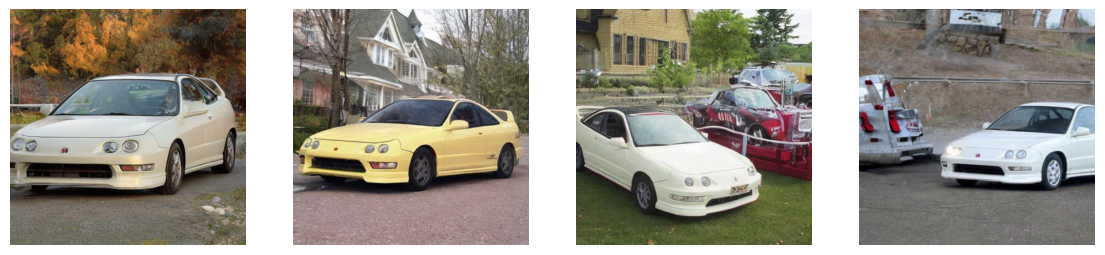

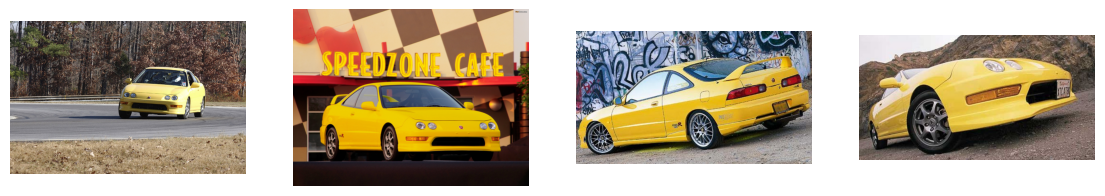

In [167]:
# Visualize examples

num_displayed_examples = 4

plt.figure(figsize=(14, 10))

for k in range(num_displayed_examples):
  plt.subplot(1, 4, k + 1)
  plt.imshow((cars_synth[k]))
  plt.axis('off')
  print(cars_synth[k].shape)
  print(cars_synth[k].dtype)

plt.figure(figsize=(14, 10))
for k in range(num_displayed_examples):
  plt.subplot(1, 4, k + 1)
  plt.imshow((cars_real[k]))
  plt.axis('off')
  print(cars_real[k].shape)
  print(cars_real[k].dtype)


In [8]:
# Image parameters
# Based on shape of fake images

im_width = 512
im_height = 512
num_channels = 3

In [9]:
# Scaling the images 

def scale_and_shift(image): 
    # Convert from uint8 to float32 and Normalize
    #image_scaled = 2 * ((image.astype(np.float32)) / 255.0) - 1
    image_scaled = (image.astype(np.float32))/image.max() 
    return image_scaled


scaled_cars_synth = [scale_and_shift(im) for im in cars_synth]
scaled_cars_real = [scale_and_shift(im) for im in cars_real]



print("Shape of first scaled image:", scaled_cars_synth[0].shape)
print("Value range of first scaled image:", scaled_cars_synth[0].min(), "to", scaled_cars_synth[0].max())

Shape of first scaled image: (512, 512, 3)
Value range of first scaled image: 0.0 to 1.0


In [11]:
# Image transformations: Lukas' code


def resize_img(image, shape, p=1.0):
    x, y = shape
    resize = A.Resize(height=x, width=y, p=p)  # pass height and width separately

    augmented = resize(image=image)
    return augmented['image']

# compression function based on image type (assuming only JPEG or PNG)
def simulate_compression(image, image_type, compress_to_jpeg=False):
    if image_type in ['.jpg', '.jpeg'] or compress_to_jpeg:
        # JPEG compression (lossy) 
        compress = A.ImageCompression(quality_range=(95,95), compression_type='jpeg', p=1.0) # compression quality of 95%
    elif image_type == '.png':
        # PNG compression (lossless) - using simulated lossless webp compression 
        compress = A.ImageCompression(quality_range=(95,95), compression_type='webp', p=1.0)  
    augmented = compress(image=image)
    return augmented['image']
  

def apply_mask(image, mask_color=(0, 0, 0), precentage_masking = 0.1):
    h, w, _ = image.shape
    p = precentage_masking
    mask_size=(p*h, p*w) # mask size dependent on size of image, to reduce loss of information/ identifiable threshold
    mask = np.ones_like(image) * 255  
    x = randint(0, round(w - mask_size[0])) # location
    y = randint(0, round(h - mask_size[1]))
    mask[y:round(y + mask_size[1]), x:round(x + mask_size[0])] = mask_color

    masked_image = cv2.bitwise_and(image, mask)   
    return masked_image

def transform_images(image_list, image_paths, target_size=None, compression=False, compress_to_jpeg = False, mask = False):
    transformed_images = []
    # apply all transformations individually for each image
    for img, img_path in zip(image_list, image_paths):
        _, ext = os.path.splitext(img_path) # check the file extension to determine the image type
        ext = ext.lower() 

        transformed_image = img # original image

        if target_size: 
            transformed_image = resize_img(transformed_image, target_size)  

        if compression: 
            transformed_image = simulate_compression(transformed_image, ext, compress_to_jpeg)

        if mask:
            transformed_image = apply_mask(transformed_image)

        transformed_images.append(transformed_image)  # add the transformed image to the list

    return transformed_images

# Synthetic cars

In [12]:
# Image augmentation using Albumentations

# Defining the augumentaton pipeline

#transform = A.Compose([
    #A.Resize(height=256, width=256, p=1),
    #A.GaussianBlur(blur_limit=(3,7), sigma_limit=0.8, p=0.8),
    #A.CenterCrop(width=im_width//2, height=im_height//2, p=0.5)])

#ransformed_synth_cars = []
#for image in scaled_cars_synth: 
#    transformed = transform(image=image)
#    transformed_synth_cars.append(transformed)



In [101]:
# Lukas' code

# specify the target size for resizing
target_size = (256, 256)

# transforming the synthetic images once (resize + compression simulation)
transformed_synth_cars = transform_images(cars_synth, fake_images_paths, target_size=target_size, compression=True, compress_to_jpeg=True, mask = True)



# transforming images 20 times, simulating online life
def return_image_array(image_list, image_paths):
    img = image_list
    for _ in range(20): 
        # resizing done once, as well as "converting" to jpeg via jpeg compression in the first step
        transformed_images = transform_images(img, image_paths, target_size=target_size, compression=True, compress_to_jpeg=True, mask = True)
        img = transformed_images
    return img

In [110]:
# Applying the transformation multiple times

transformed_synth_cars = return_image_array(cars_synth, fake_images_paths)

In [111]:
# Resize the original synthetic images to match the shape of the transformed synthetic images

# Modified code to transform multiple times and compute psnr

def multiple_transform_psnr(image_list, image_paths, target_size=None):

    
    img = image_list
    transformed_images_list = []  # To store transformed images at each iteration
    psnr_values = []  # To store PSNR values at each iteration

    # Keep the original images for PSNR calculation
    original_images = image_list

    for _ in range(50):

        # Perform transformation
        transformed_images = transform_images(img, image_paths, target_size=target_size, compression=True, compress_to_jpeg=True, mask=False)
        
        # Store transformed images
        transformed_images_list.append(transformed_images)

        # Compute PSNR for each image
        iteration_psnrs = []
        for j in range(len(original_images)):
            # Resize original image to match transformed image shape
            reshaped_original = resize(original_images[j], transformed_images[j].shape, anti_aliasing=True, preserve_range=True)

            # Calculate PSNR
            psnr_value = psnr(reshaped_original, transformed_images[j], data_range=reshaped_original.max() - reshaped_original.min())
            iteration_psnrs.append(psnr_value)
        
        # Average PSNR for the iteration
        psnr_values.append(sum(iteration_psnrs) / len(iteration_psnrs))

        # Update images for the next iteration
        img = transformed_images


    return transformed_images_list, psnr_values



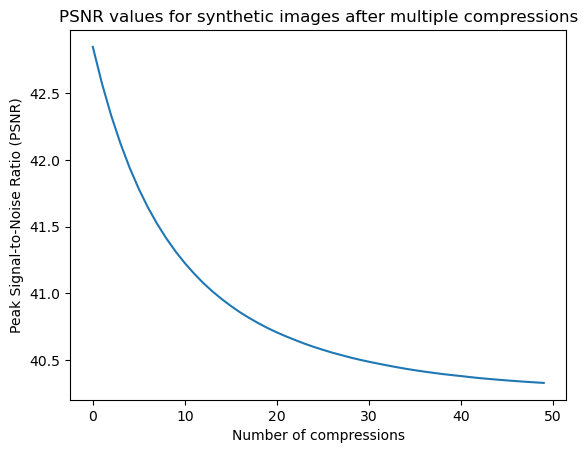

In [92]:
# Plotting PSNR values

compressed_synthetic, psnr_synthetic = multiple_transform_psnr(cars_synth, fake_images_paths)

plt.plot(range(len(compressed_synthetic)), psnr_synthetic)  
plt.xlabel("Number of compressions") 
plt.ylabel("Peak Signal-to-Noise Ratio (PSNR)")
plt.title("PSNR values for synthetic images after multiple compressions")
plt.show()


In [112]:
print("Original image shape:", scaled_cars_synth[0].shape)
print("Transformed image shape:", transformed_synth_cars[0].shape)

Original image shape: (512, 512, 3)
Transformed image shape: (256, 256, 3)


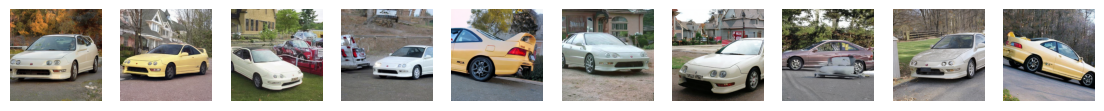

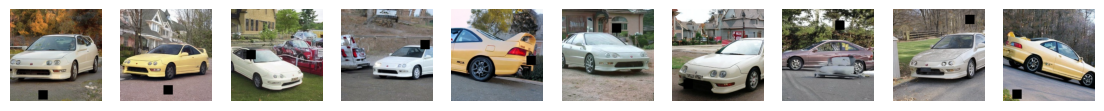

In [106]:
# Visualize examples

num_displayed_examples =  10

plt.figure(figsize=(14, 10))
#plt.title("Original images")
#plt.axis('off')
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow((scaled_cars_synth[k]))
  plt.axis('off')


plt.figure(figsize=(14, 10))
#plt.title("Transformed images")
#plt.axis('off')
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  #plt.imshow((transformed_synth_cars[k]['image']))
  plt.imshow((transformed_synth_cars[k]))
  plt.axis('off')


In [113]:
# Frequency analysis of images

pow_spec_all = []
spec_all = []

# TRANSFORMED SYNTHETIC IMAGES
for k in range(num_displayed_examples): 

    #image_data = transformed_synth_cars[k]['image']
    image_data = transformed_synth_cars[k]

    for channel in range(image_data.shape[2]):  # Loop over RGB channels
        channel_data = image_data[..., channel]

        # Compute power spectrum for this channel
        f_transform = np.fft.fft2(channel_data)
        f_transform_shifted = np.fft.fftshift(f_transform)
        pow_spec = np.abs(f_transform_shifted) ** 2 

        
    # Computing the power spectrum
    spec = np.fft.fftshift(np.fft.fft2(channel_data))
    spec = np.abs(spec)
    spec = np.log(spec + 1)
    spec_all.append(spec)
    

    # Creating a radial grid
    ny, nx = pow_spec.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)


    # Radial binning 
    r = r.astype(np.int32)
    r_max = r.max()
    psd = np.bincount(r.ravel(), weights=pow_spec.ravel()) / np.bincount(r.ravel())
    pow_spec_all.append(psd)    

    # Generate frequencies for plotting
    freqs = np.arange(len(psd))  # Frequencies for the PSD (normalized)


synth_org_pow_spec_all = []
synth_org_spec_all = []

# NOT TRANSFORMED SYNTHETIC IMAGES
for k in range(num_displayed_examples): 

    image_data = scaled_cars_synth[k]

    for channel in range(image_data.shape[2]):  # Loop over RGB channels
        channel_data = image_data[..., channel]

        # Compute power spectrum for this channel
        f_transform = np.fft.fft2(channel_data)
        f_transform_shifted = np.fft.fftshift(f_transform)
        pow_spec = np.abs(f_transform_shifted) ** 2 

        
    # Computing the power spectrum
    spec = np.fft.fftshift(np.fft.fft2(channel_data))
    spec = np.abs(spec)
    spec = np.log(spec + 1)
    synth_org_spec_all.append(spec)
    

    # Creating a radial grid
    ny, nx = pow_spec.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)


    # Radial binning 
    r = r.astype(np.int32)
    r_max = r.max()
    psd = np.bincount(r.ravel(), weights=pow_spec.ravel()) / np.bincount(r.ravel())
    synth_org_pow_spec_all.append(psd)    

    # Generate frequencies for plotting
    freqs = np.arange(len(psd))  # Frequencies for the PSD (normalized)



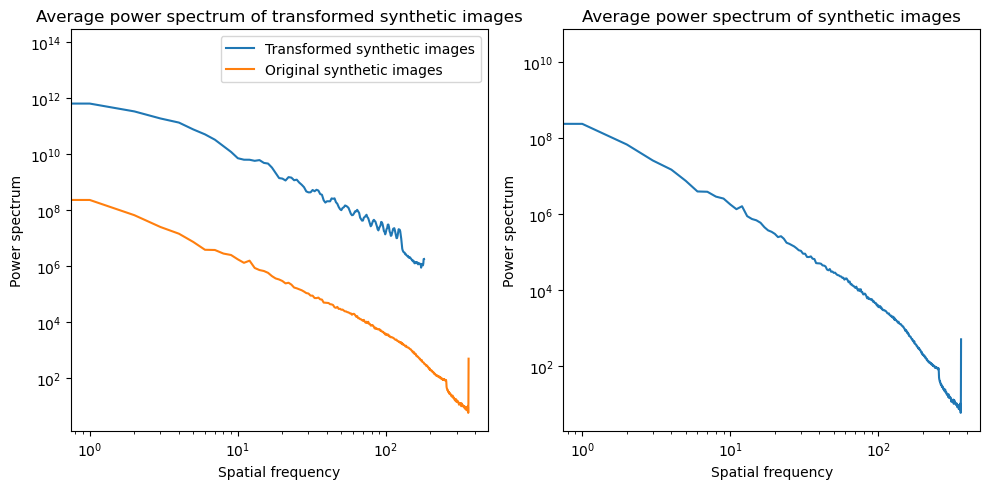

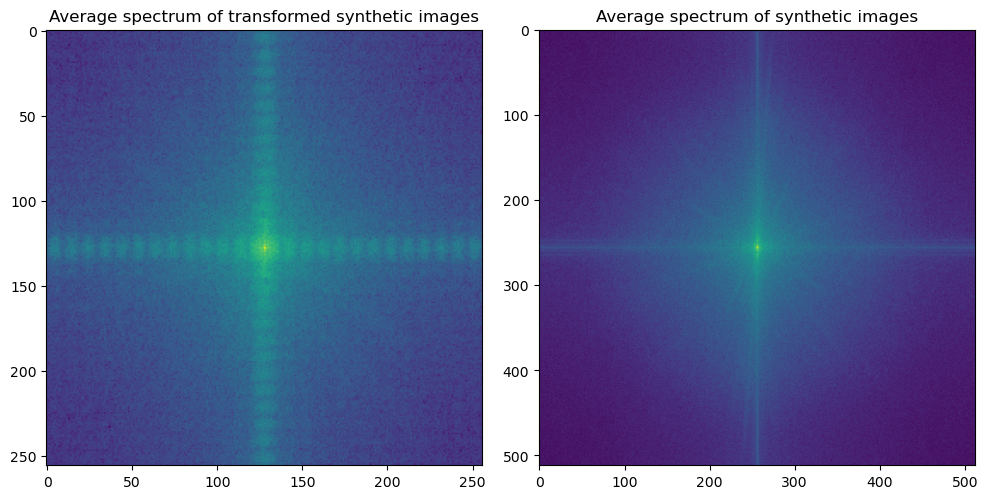

In [116]:
# AVERAGING - Synthetic transformed

# Average power spectrum 

for i in range(len(pow_spec_all)):
    if i == 0:
        avg_pow_spec = pow_spec_all[i]
    else:
        avg_pow_spec += pow_spec_all[i]

avg_pow_spec = avg_pow_spec/len(pow_spec_all)

# Average spectrum

for i in range(len(spec_all)):
    if i == 0:
        avg_spec = spec_all[i]
    else:
        avg_spec += spec_all[i] 

avg_spec = avg_spec/len(spec_all)   


# AVERAGING - Synthetic not transformed

# Average power spectrum 

for i in range(len(synth_org_pow_spec_all)):
    if i == 0:
        avg_synth_org_pow_spec = synth_org_pow_spec_all[i]
    else:
        avg_synth_org_pow_spec += synth_org_pow_spec_all[i]

avg_synth_org_pow_spec = avg_synth_org_pow_spec/len(synth_org_pow_spec_all)

# Average spectrum

for i in range(len(synth_org_spec_all)):
    if i == 0:
        avg_synth_org_spec = synth_org_spec_all[i]
    else:
        avg_synth_org_spec += synth_org_spec_all[i] 

avg_synth_org_spec = avg_synth_org_spec/len(synth_org_spec_all)   

# Plotting the average power spectrum   
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_pow_spec, label="Transformed synthetic images")
plt.plot(avg_synth_org_pow_spec,  label="Original synthetic images")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Spatial frequency")
plt.ylabel("Power spectrum")
plt.title("Average power spectrum of transformed synthetic images") 

plt.subplot(1, 2, 2)
plt.plot(avg_synth_org_pow_spec)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Spatial frequency")
plt.ylabel("Power spectrum")
plt.title("Average power spectrum of synthetic images") 

plt.tight_layout()
plt.show()

# Plotting the average spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(avg_spec)
#plt.axis('off')
plt.title("Average spectrum of transformed synthetic images")


plt.subplot(1, 2, 2)
plt.imshow(avg_synth_org_spec)
#plt.axis('off')
plt.title("Average spectrum of synthetic images")

plt.tight_layout()
plt.show()




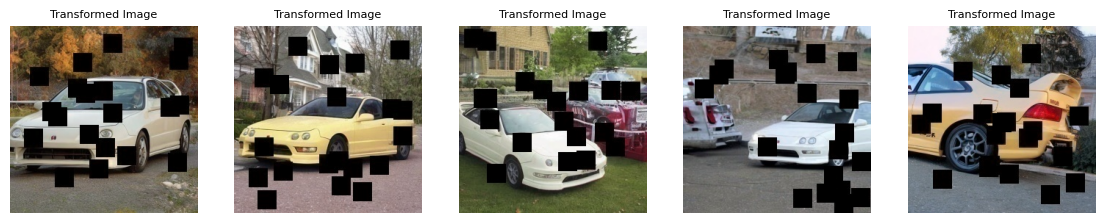

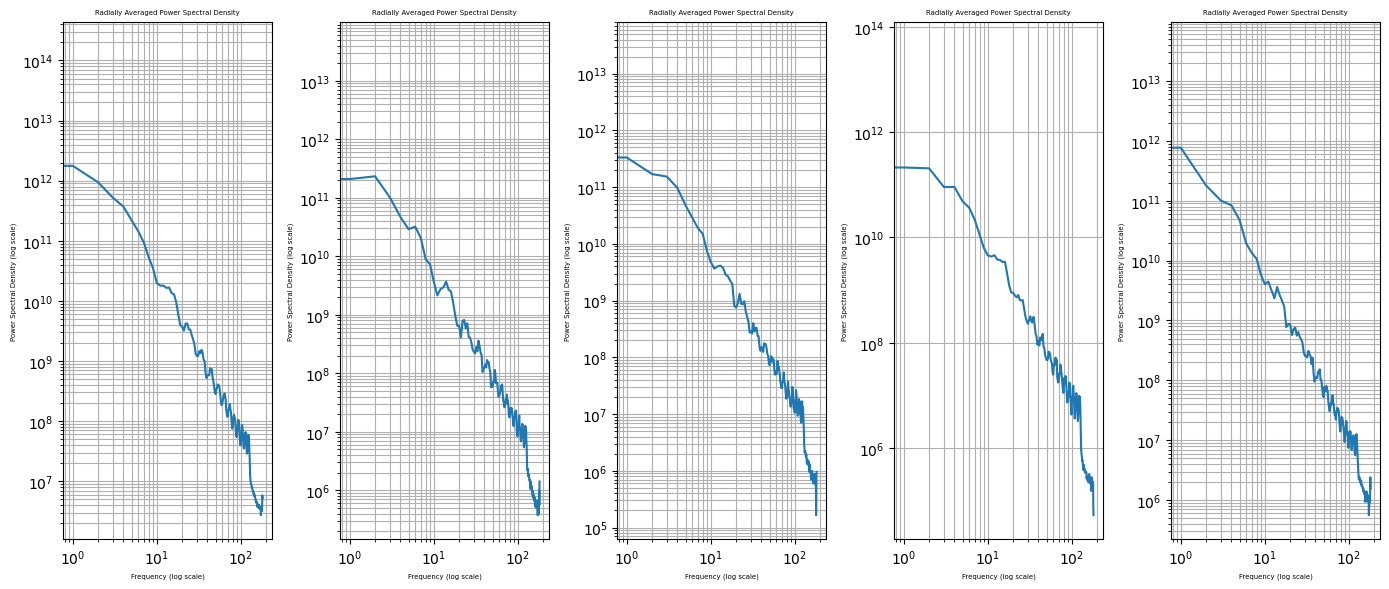

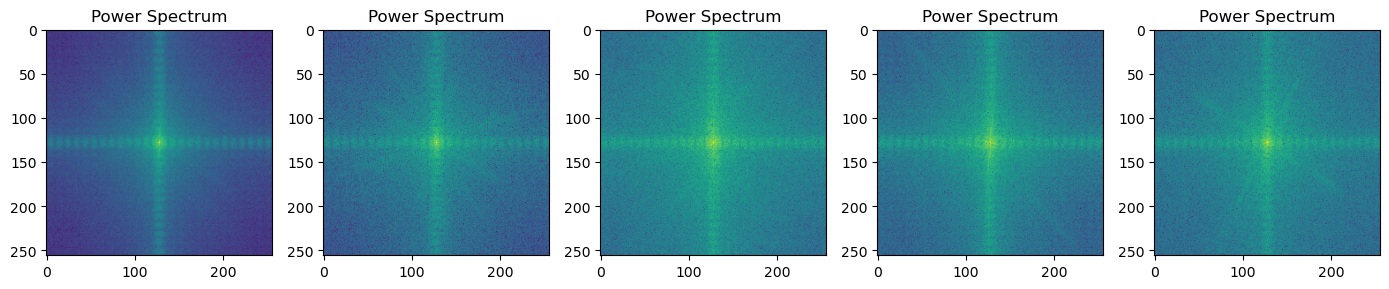

In [115]:
# Plotting

num_displayed_examples = 5

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  #plt.imshow(transformed_synth_cars[k]['image'])
  plt.imshow(transformed_synth_cars[k])
  plt.title("Transformed Image", size=8)
  plt.axis('off')
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.plot(pow_spec_all[k]) 
  plt.xscale("log")
  plt.yscale("log")
  plt.xlabel("Frequency (log scale)", size=5)
  plt.ylabel("Power Spectral Density (log scale)", size=5)
  plt.title("Radially Averaged Power Spectral Density", size=5)
  plt.grid(which="both")
  plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow(spec_all[k])
  plt.title("Power Spectrum")
  plt.tight_layout()
plt.show()


# Real cars

In [176]:
# Image augmentation using Albumentations

# Defining the augumentaton pipeline

transformed_real_cars = []
for image in scaled_cars_real: 
    transformed = transform(image=image)
    transformed_real_cars.append(transformed)



In [177]:
print("Original image shape:", scaled_cars_real[0].shape)
print("Transformed image shape:", transformed_real_cars[0]['image'].shape) 

Original image shape: (326, 500, 3)
Transformed image shape: (256, 256, 3)


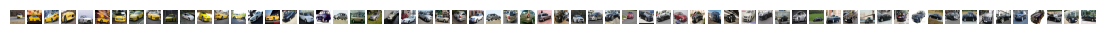

In [178]:
# Visualize examples


plt.figure(figsize=(14, 10))
#plt.title("Original images")
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow((scaled_cars_real[k]))
  plt.axis('off')


plt.figure(figsize=(14, 10))
#plt.title("Transformed images")
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow((transformed_real_cars[k]['image']))
  plt.axis('off')

In [197]:
# Frequency analysis of images

real_pow_spec_all = []
real_spec_all = []


for k in range(num_displayed_examples): 

    image_data = transformed_real_cars[k]['image']

    for channel in range(image_data.shape[2]):  # Loop over RGB channels
        channel_data = image_data[..., channel]

        # Compute power spectrum for this channel
        f_transform = np.fft.fft2(channel_data)
        f_transform_shifted = np.fft.fftshift(f_transform)
        pow_spec = np.abs(f_transform_shifted) ** 2 

        
    # Computing the power spectrum
    spec = np.fft.fftshift(np.fft.fft2(channel_data))
    spec = np.abs(spec)
    spec = np.log(spec + 1)
    real_spec_all.append(spec)
    

    # Creating a radial grid
    ny, nx = pow_spec.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)


    # Radial binning 
    r = r.astype(np.int32)
    r_max = r.max()
    psd = np.bincount(r.ravel(), weights=pow_spec.ravel()) / np.bincount(r.ravel())
    real_pow_spec_all.append(psd)    

    # Generate frequencies for plotting
    freqs = np.arange(len(psd))  # Frequencies for the PSD (normalized)



# Not transformed real images

org_real_pow_spec_all = []
org_real_spec_all = []


for k in range(num_displayed_examples): 

    image_data = scaled_cars_real[k]

    for channel in range(image_data.shape[2]):  # Loop over RGB channels
        channel_data = image_data[..., channel]

        # Compute power spectrum for this channel
        f_transform = np.fft.fft2(channel_data)
        f_transform_shifted = np.fft.fftshift(f_transform)
        pow_spec = np.abs(f_transform_shifted) ** 2 

        
    # Computing the power spectrum
    spec = np.fft.fftshift(np.fft.fft2(channel_data))
    spec = np.abs(spec)
    spec = np.log(spec + 1)
    org_real_spec_all.append(spec)
    

    # Creating a radial grid
    ny, nx = pow_spec.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)


    # Radial binning 
    r = r.astype(np.int32)
    r_max = r.max()
    psd = np.bincount(r.ravel(), weights=pow_spec.ravel()) / np.bincount(r.ravel())
    org_real_pow_spec_all.append(psd)    

    # Generate frequencies for plotting
    freqs = np.arange(len(psd))  # Frequencies for the PSD (normalized)



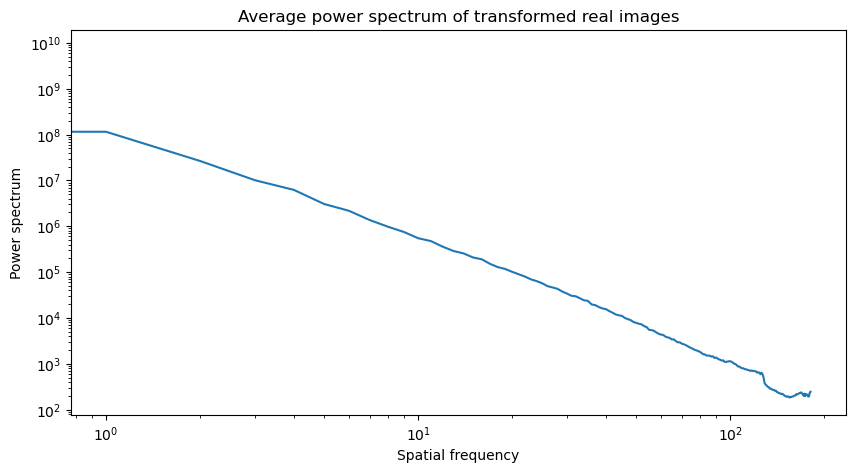

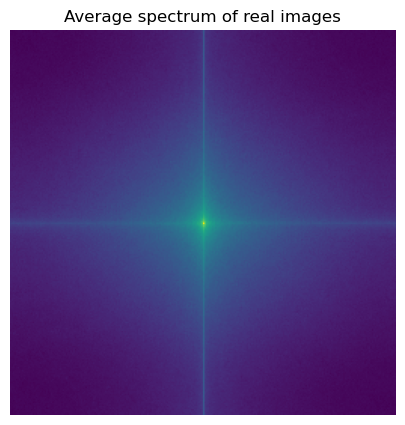

In [206]:
# AVERAGING - REAL TRANSFORMED

# Average power spectrum 

for i in range(len(real_pow_spec_all)):
    if i == 0:
        real_avg_pow_spec = real_pow_spec_all[i]
    else:
        real_avg_pow_spec += real_pow_spec_all[i]

real_avg_pow_spec = real_avg_pow_spec/len(real_pow_spec_all)


# Average spectrum

for i in range(len(real_spec_all)):
    if i == 0:
        real_avg_spec = real_spec_all[i]
    else:
        real_avg_spec += real_spec_all[i] 

real_avg_spec = real_avg_spec/len(real_spec_all)   



# Plotting the average power spectrum   
plt.figure(figsize=(10, 5))
plt.plot(real_avg_pow_spec)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Spatial frequency")
plt.ylabel("Power spectrum")
plt.title("Average power spectrum of transformed real images") 

plt.show()

# Plotting the average spectrum
plt.figure(figsize=(10, 5))

plt.imshow(real_avg_spec)
plt.axis('off')
plt.title("Average spectrum of real images")

plt.show()



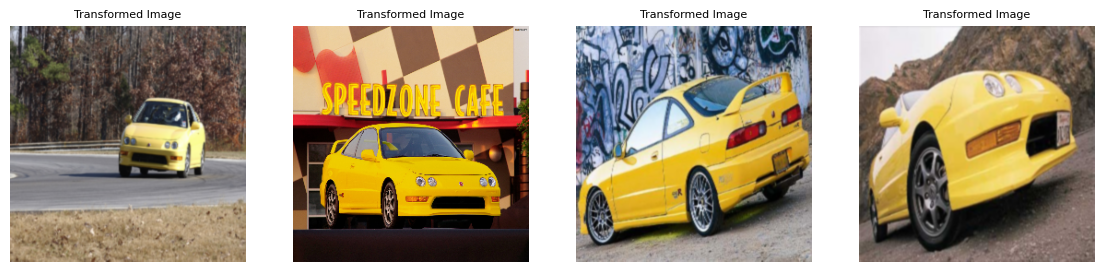

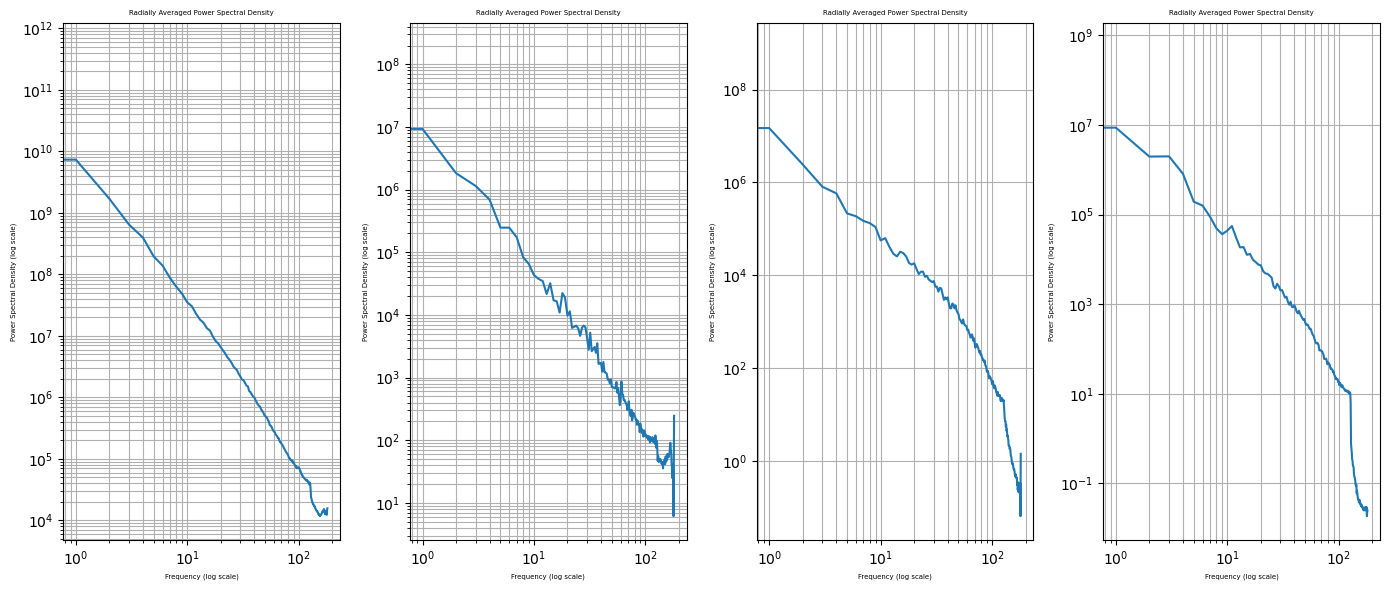

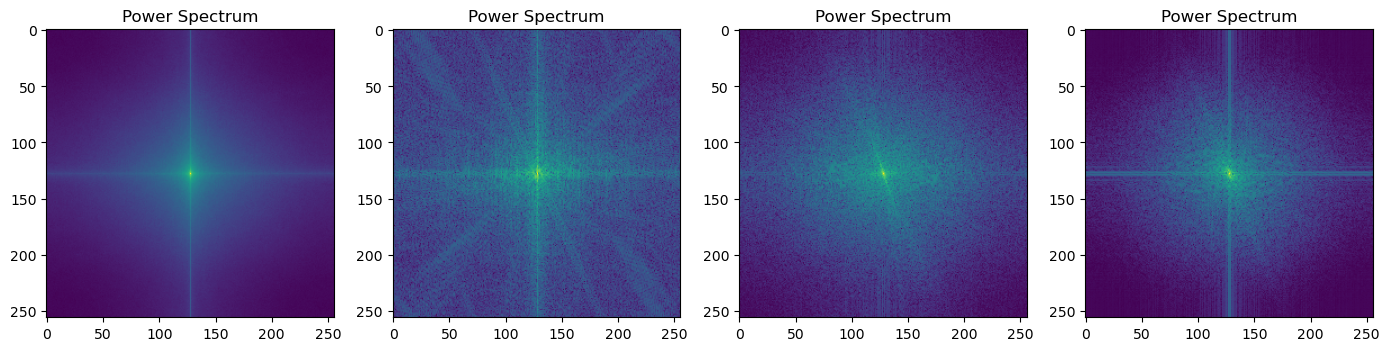

In [212]:
# Plotting

num_displayed_examples = 4  

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow(transformed_real_cars[k]['image'])
  plt.title("Transformed Image", size=8)
  plt.axis('off')
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.plot(real_pow_spec_all[k]) 
  plt.xscale("log")
  plt.yscale("log")
  plt.xlabel("Frequency (log scale)", size=5)
  plt.ylabel("Power Spectral Density (log scale)", size=5)
  plt.title("Radially Averaged Power Spectral Density", size=5)
  plt.grid(which="both")
  plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow(real_spec_all[k])
  plt.title("Power Spectrum")
  plt.tight_layout()
plt.show()

